In [2]:
!pwd

/Users/avnishkanungo/Desktop/Purdue /ECE60146/DLStudio/DLStudio-2.3.3 2/Examples


In [3]:
import os, sys
import torch
import torchvision.transforms as tvt
from PIL import Image
import numpy as np
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tvt
from torchvision import utils
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import skimage.io as io
from pycocotools.coco import COCO

In [27]:
dataDir='/Users/avnishkanungo/Desktop/coco-dataset/train2017/train2017'
dataType='train2017'
annFile='/Users/avnishkanungo/Desktop/coco-dataset/train2017/train2017/annotations/instances_train2017.json'.format(dataDir,dataType)
annFile

'/Users/avnishkanungo/Desktop/coco-dataset/train2017/train2017/annotations/instances_train2017.json'

In [20]:
coco_cnn = COCO(annFile) #Load annotations in the memory and index them

loading annotations into memory...
Done (t=25.07s)
creating index...
index created!


In [29]:
#####CODE TO GENERATE DATASET#########################
def create_train_test_data(classes, coco):
    # create folders
    data_dir="/Users/avnishkanungo/Desktop/coco-dataset/train2017/train2017" #define the directory where the complete COCO 2017 traing images are
    
    # define location of the directories where the training and test data that we are going to us is to be saved, structured as per their lable
    for c in classes:
        training_path = "/Users/avnishkanungo/Desktop/coco-dataset/train2017/hw4_dataset/train_data_CNN" + "/" + c 
        testing_path = "/Users/avnishkanungo/Desktop/coco-dataset/train2017/hw4_dataset/test_data_CNN" + "/" + c
        
        # creating directories if they do not exist
        if not os.path.exists(training_path):
            os.makedirs(training_path)
        if not os.path.exists(testing_path):
            os.makedirs(testing_path)

        catIds = coco.getCatIds(catNms=c) # get category ids, i.e. the IDs to reference the class of images we want
        training_data = dict(zip(classes, [[] for i in range(len(classes))]))
        testing_data = dict(zip(classes, [[] for i in range(len(classes))]))
        print(f"dataset generation has started for {c} ")
        for i, idx in enumerate(catIds):
            imgIds = coco.getImgIds(catIds=idx) # get the image Ids for the category id in each iteration
            imgIds = np.random.choice(imgIds, size=2000, replace=False) #randomly select 2000 the image Ids for the category id in each iteration
            for j, jdx in enumerate(imgIds):
                image_file_name = coco.loadImgs(int(jdx))[0]['file_name']
                img_file_path = os.path.join(data_dir, f"train2017/{image_file_name}")
                img = Image.open(img_file_path).convert("RGB") #Iterate over and load the random 2000 images, ensure all images are RGB as the 
                img = img.resize((64, 64)) # resize            #neural net to be used is configured for 3 channel input, and resize to 64x64
                save_name = image_file_name
                if j < 1599: #Iteration to save the first 1600 images to Training directory
                    save_dir = "/Users/avnishkanungo/Desktop/coco-dataset/train2017/hw4_dataset/train_data_CNN" + "/" + c
                    training_data[classes[i]].append(image_file_name)
                else: #Iteration to save the remainign 400 images to Testing directory
                    save_dir = "/Users/avnishkanungo/Desktop/coco-dataset/train2017/hw4_dataset/test_data_CNN" + "/" + c
                    testing_data[classes[i]].append(image_file_name)
                img.save(os.path.join(save_dir, save_name))
    print("train and validation datasets are ready!")

In [8]:
classes = ['boat', 'couch', 'dog', 'cake', 'motorcycle']

In [30]:
create_train_test_data(classes, coco_cnn)

dataset generation has started for boat 
dataset generation has started for couch 
dataset generation has started for dog 
dataset generation has started for cake 
dataset generation has started for motorcycle 
train and validation datasets are ready!


In [4]:
####CODE To SETUP TORCH DATASET########################################
class myCOCODataSet(Dataset):
    def __init__(self, file_path, classes, transform=None):
        super (). __init__ ()
        self.file_path = file_path
        self.classes = classes
        self.image_path = []
        self.class_label = []
        for c in classes:
            image_file_path = os.path.join(file_path, c)
            image_label = self.classes.index(c)
            for l in os.listdir(image_file_path):
                self.image_path.append(os.path.join(image_file_path,l))
                self.class_label.append(image_label)
            
        self.transform = transform

    def __len__(self):
        return len(self.class_label)

    def __getitem__(self, idx):
        image_name_path = self.image_path[idx]
        actual_image_lable = self.class_label[idx]
        ##img_path = os.path.join(self.file_path, self.file_names[idx])
        actual_image = Image.open(image_name_path)
        ##og_image = io.imread(img_path)
        ##class_name = self.file_names[idx].split("_")[0] # get the index of label
        ##label = self.classes.index(class_name) # get label
        if self.transform:
           actual_image = self.transform(actual_image)

        return actual_image, actual_image_lable

In [5]:
file_path_train = '/Users/avnishkanungo/Desktop/coco-dataset/train2017/hw4_dataset/train_data_CNN'
file_path_test = '/Users/avnishkanungo/Desktop/coco-dataset/train2017/hw4_dataset/test_data_CNN'

In [6]:
xform = tvt.Compose([
    tvt.ToTensor()])

In [80]:
my_dataset_test = myCOCODataSet(file_path = file_path_test, classes = classes ,transform = xform )
my_dataset_train = myCOCODataSet(file_path = file_path_train, classes = classes ,transform = xform )

In [81]:
len(my_dataset_train)

8000

In [82]:
def plot_train_test_image_sample(dataset,classes_plot):
    # Create a dictionary to store indices of images for each class
    class_indices = {class_name: [] for class_name in classes_plot}
    
    # Iterate through the dataset to collect indices for each class
    for idx, (image, label) in enumerate(dataset):
        class_indices[classes[label]].append(idx)
    
    # Display 5 random images from each class
    num_samples_per_class = 3
    fig, axes = plt.subplots(len(classes), num_samples_per_class, figsize=(12, 12))
    
    for i, class_name in enumerate(classes):
        indices = class_indices[class_name]
        random_indices = np.random.choice(indices, num_samples_per_class, replace=False)
        
        for j, idx in enumerate(random_indices):
            image, label = dataset[idx]
            image = np.transpose(image.numpy(), (1, 2, 0))
            axes[i, j].imshow(image)
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

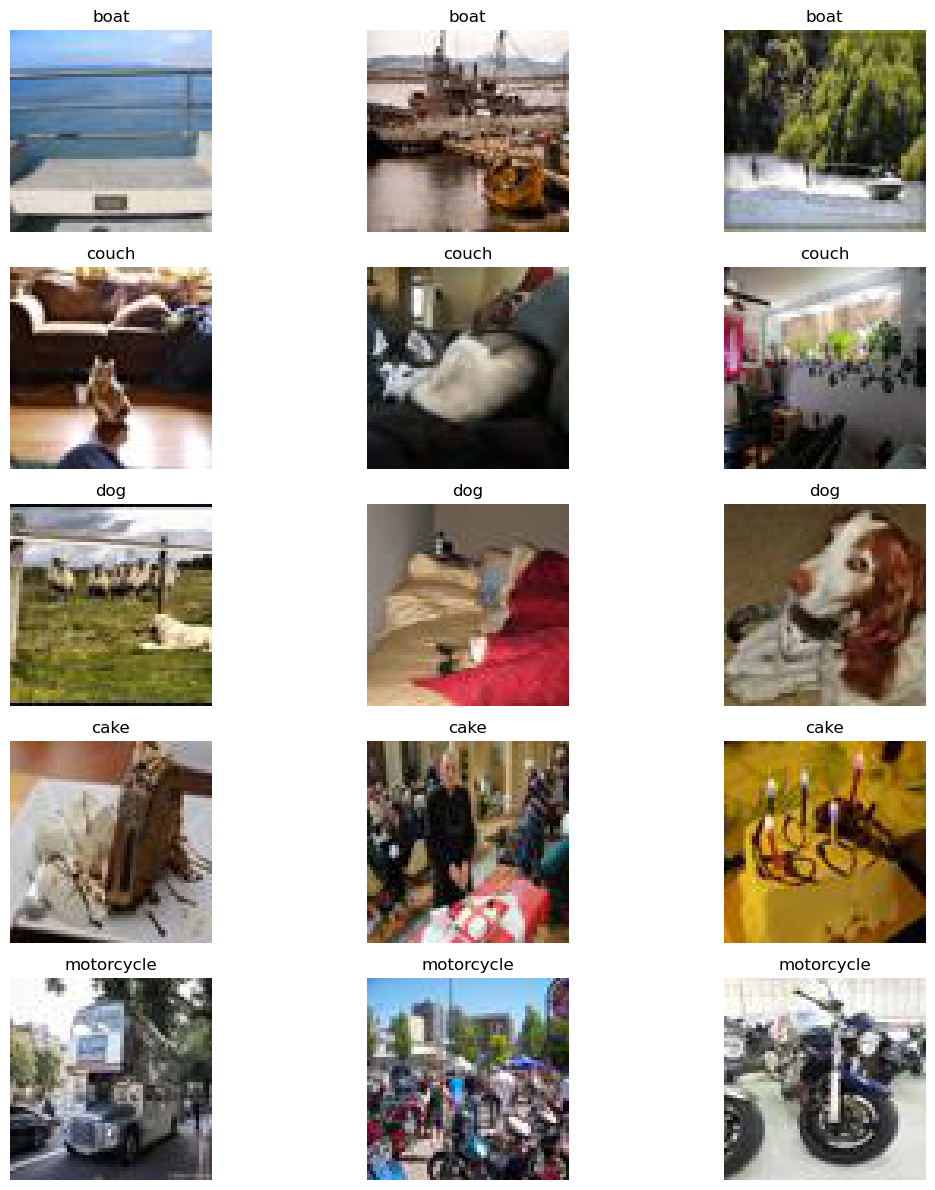

In [124]:
plot_train_test_image_sample(my_dataset_train, classes)

In [84]:
train_dataloader = DataLoader(my_dataset_train, batch_size = 4, shuffle=True)
test_dataloader = DataLoader(my_dataset_test,batch_size = 4, shuffle=True)

In [121]:
def weights_init(m): # to prevent vanishing gradient problem in Net3
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        #if m.bias:
        #    torch.nn.init.xavier_uniform_(m.bias)

In [168]:
###########Neural Network Creation and Configuration##################################
####The neural network code is in part  configured by referenceing previous year's homework.####
class HW4Net(nn.Module):
    def __init__(self, net):
        super(HW4Net, self).__init__()
        self.net = net
        #net.apply(weights_init)
        if self.net == 'Net1':
            self.conv1 = nn.Conv2d(3, 16, 3) #62 X 62 X 16
            self.pool = nn.MaxPool2d(2,2) ## 31 X 31 X 16
            self.conv2 = nn.Conv2d(16, 32, 3) ## 28 X 28 X 32
            self.fc1 = nn.Linear( 14 * 14 * 32, 64) ## 14 X 14 X 32 post second maxpool
            self.fc2 = nn.Linear(64, 5) #as there are 5 classes
        elif self.net == 'Net2':
            self.conv1 = nn.Conv2d(3, 16, 3, padding = 1) #64 X 64 X 16
            self.pool = nn.MaxPool2d(2,2) # 32 X 32 X 16
            self.conv2 = nn.Conv2d(16, 32, 3, padding = 1) # 32 X 32 X 32
            self.fc1 = nn.Linear(16 * 16 * 32, 64) ## 16 X 16 X 32 post second maxpool
            self.fc2 = nn.Linear(64, 5)
        elif self.net == 'Net3':
            self.conv1 = nn.Conv2d(3, 16, 3, padding=  1)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
            self.conv_layers = nn.ModuleList()
            self.conv_layers = nn.ModuleList([nn.Conv2d(32, 32, 3, padding=  1) for _ in range(10)])
            self.fc1 = nn.Linear(16 * 16 * 32, 64) ## 6 X 16 X 32 post second maxpool
            self.fc2 = nn.Linear(64, 5)

    def forward(self, x):
        if self.net == 'Net1':
            x = self.pool(F.relu(self.conv1(x))) 
            x = self.pool(F.relu(self.conv2(x))) 
            x = x.view(x.shape[0], -1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x
        elif self.net == 'Net2':
            x = self.pool(F.relu(self.conv1(x))) 
            x = self.pool(F.relu(self.conv2(x))) 
            x = x.view(x.shape[0], -1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x
        elif self.net == 'Net3':
            x = self.pool(F.leaky_relu(self.conv1(x))) #Leaky relu used here in effeor to minimze the vanishing gradient problem.
            x = self.pool(F.leaky_relu(self.conv2(x))) #Leaky relu used here in effeor to minimze the vanishing gradient problem.
            for conv_layer in self.conv_layers:
                x = F.leaky_relu(conv_layer(x)) #Leaky relu used here in effeor to minimze the vanishing gradient problem.
            x = x.view(x.shape[0], -1)
            x = F.leaky_relu(self.fc1(x))
            x = self.fc2(x)
            return x

In [116]:
# ###########Neural Network Creation and Configuration##################################
# ####The neural network code is in part  configured by referenceing previous year's homework.####
# class HW4Net(nn.Module):
#     def __init__(self, net):
#         super(HW4Net, self).__init__()
#         self.net = net
#         #net.apply(weights_init)
#         if self.net == 'Net1':
#             self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3) #62 X 62 X 16
#             self.pool = nn.MaxPool2d(kernel_size=2,stride=2) ## 31 X 31 X 16
#             self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3) ## 28 X 28 X 32
#             self.fc1 = nn.Linear(in_features= 28 * 28 * 8, out_features=64) ## 28 X 28 X 32 divided by (batch size)
#             self.fc2 = nn.Linear(in_features=64, out_features=5) #as there are 5 classes
#         elif self.net == 'Net2':
#             self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1) #64 X 64 X 16
#             self.pool = nn.MaxPool2d(kernel_size=2,stride=2) # 32 X 32 X 16
#             self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) # 32 X 32 X 32
#             self.fc1 = nn.Linear(in_features=32 * 32 * 8, out_features=64) ## 32 X 32 X 32 divided by (batch size)
#             self.fc2 = nn.Linear(in_features=64, out_features=5)
#         elif self.net == 'Net3':
#             self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
#             self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
#             self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
#             self.conv_layers = nn.ModuleList()
#             self.conv_layers = nn.ModuleList([nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1) for _ in range(10)])
#             self.fc1 = nn.Linear(in_features=32 * 32 * 8, out_features=64) ## 32 X 32 X 32 divided by (batch size)
#             self.fc2 = nn.Linear(in_features=64, out_features=5)

#     def forward(self, x):
#         if self.net == 'Net1':
#             x = self.pool(F.relu(self.conv1(x))) 
#             x = self.pool(F.relu(self.conv2(x))) 
#             x = x.view(x.shape[0], -1)
#             x = F.relu(self.fc1(x))
#             x = self.fc2(x)
#             return x
#         elif self.net == 'Net2':
#             x = self.pool(F.relu(self.conv1(x))) 
#             x = self.pool(F.relu(self.conv2(x))) 
#             x = x.view(x.shape[0], -1)
#             x = F.relu(self.fc1(x))
#             x = self.fc2(x)
#             return x
#         elif self.net == 'Net3':
#             x = self.pool(F.leaky_relu(self.conv1(x))) #Leaky relu used here in effeor to minimze the vanishing gradient problem.
#             x = self.pool(F.leaky_relu(self.conv2(x)))
#             for conv_layer in self.conv_layers:
#                 x = F.leaky_relu(conv_layer(x)) 
#             x = x.view(x.shape[0], -1)
#             x = F.leaky_relu(self.fc1(x))
#             x = self.fc2(x)
#             return x
    

In [164]:
## This code has been taken from Professor Kak' DL Studio Model and 
## and in part also configured by referenceing previous year's homework.

def model_training(net, epochs, train_data_loader, device, save_path):
    training_loss = []
    criterion = torch.nn.CrossEntropyLoss() #Loss Function
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.99)) #Optimizer
    print("Begin Training...\n")
    net = net.to(device) #Configure Device
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_data_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() #initializer gradient values to zero
            outputs = net(inputs) #forward pass
            loss = criterion(outputs, labels) # loss calculated as per the cost function
            loss.backward() #backpropogation of the loss
            optimizer.step()  #step optimization as per the optimizer configured
            running_loss += loss.item()
            if (i + 1) % 100 == 0:
                print("[epoch: %d, batch: %5d] loss: %3f" % (epoch + 1, i + 1, running_loss / 100))
                training_loss.append(running_loss / 100)
                running_loss = 0.0
    print("Finished Training!\n")
    torch.save(net.state_dict(), save_path)
    return training_loss

In [165]:
## This code has been taken from Professor Kak' DL Studio Model and 
## and in part also configured by referenceing previous year's homework.

def model_testing(net, test_data_loader, batch_size, device, desired_cats, save_path):
    print("Begin Evaluation...\n")
    net.load_state_dict(torch.load(save_path))  #load the saved model from the .pth file
    net.eval()
    correct, total = 0, 0
    confusion_matrix = torch.zeros(5, 5)  #initialize the matrix for confusion matrix creation
    class_correct = [0] * 5
    class_total = [0] * 5
    with torch.no_grad():
        for i, data in enumerate(test_data_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            output = net(inputs) #forward pass
            _, predicted = torch.max(output.data, 1) #extracting index of the max value, as that is basically the label we are looking for
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            comp = predicted == labels
            for label, prediction in zip(labels, predicted):
                confusion_matrix[label][prediction] += 1 #creating the 
            for j in range(batch_size):
                label = labels[j]
                class_correct[label] += comp[j].item()
                class_total[label] += 1
    for j in range(5):
        print('Prediction accuracy for %5s : %2d %%' % (desired_cats[j], 100 * class_correct[j] / class_total[j]))
    print("Finished Evaluation!\n")
    print('Accuracy of the network on 2000 test images: {}%'.format(100 * float(correct / total)))
    plot_confusion_martix(confusion_matrix, 'Confusion Matrix', desired_cats)
    return confusion_matrix, float(correct / total)

In [161]:
def plot_confusion_martix(cf_matrix, title, desired_cats):
    sns.heatmap(cf_matrix, annot=True, cmap='Greens', fmt='g', xticklabels=desired_cats, yticklabels=desired_cats)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title(title)
    plt.show()

Begin Training...

[epoch: 1, batch:   100] loss: 1.615577
[epoch: 1, batch:   200] loss: 1.604489
[epoch: 1, batch:   300] loss: 1.512620
[epoch: 1, batch:   400] loss: 1.456176
[epoch: 1, batch:   500] loss: 1.454412
[epoch: 1, batch:   600] loss: 1.436183
[epoch: 1, batch:   700] loss: 1.434252
[epoch: 1, batch:   800] loss: 1.427979
[epoch: 1, batch:   900] loss: 1.397481
[epoch: 1, batch:  1000] loss: 1.338401
[epoch: 1, batch:  1100] loss: 1.326976
[epoch: 1, batch:  1200] loss: 1.391963
[epoch: 1, batch:  1300] loss: 1.283695
[epoch: 1, batch:  1400] loss: 1.257841
[epoch: 1, batch:  1500] loss: 1.364283
[epoch: 1, batch:  1600] loss: 1.307439
[epoch: 1, batch:  1700] loss: 1.307469
[epoch: 1, batch:  1800] loss: 1.269195
[epoch: 1, batch:  1900] loss: 1.317592
[epoch: 1, batch:  2000] loss: 1.300834
[epoch: 2, batch:   100] loss: 1.233341
[epoch: 2, batch:   200] loss: 1.348263
[epoch: 2, batch:   300] loss: 1.241142
[epoch: 2, batch:   400] loss: 1.231292
[epoch: 2, batch:   5

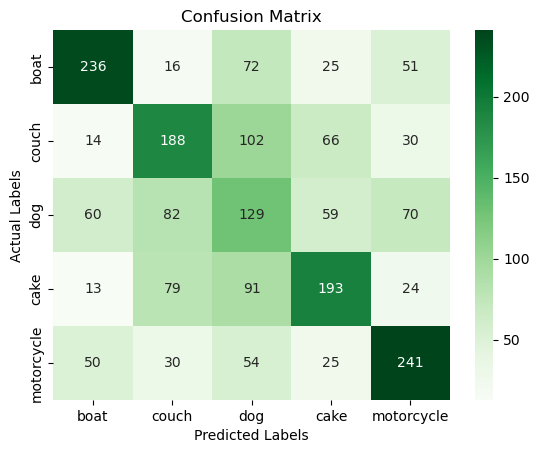

In [156]:
net1 = HW4Net("Net1")
epochs_net1 = 15
batch_size_net1 = 4
net1_training_loss = model_training(net1, epochs_net1, train_dataloader, torch.device("mps"), os.path.join('/Users/avnishkanungo/Desktop/coco-dataset/train2017', 'net1.pth'))
confusion_matrix_net1, net1_testing_acc = model_testing(net1, test_dataloader, batch_size_net1, torch.device("mps"), classes,os.path.join('/Users/avnishkanungo/Desktop/coco-dataset/train2017', 'net1.pth'))
#plot_confusion_martix(confusion_matrix_net1, 'Confusion Matrix for Net1, Accuracy: {}'.format(testing_acc_net1), classes)

Begin Training...

[epoch: 1, batch:   100] loss: 1.589577
[epoch: 1, batch:   200] loss: 1.463543
[epoch: 1, batch:   300] loss: 1.421513
[epoch: 1, batch:   400] loss: 1.417715
[epoch: 1, batch:   500] loss: 1.458348
[epoch: 1, batch:   600] loss: 1.344900
[epoch: 1, batch:   700] loss: 1.335982
[epoch: 1, batch:   800] loss: 1.358388
[epoch: 1, batch:   900] loss: 1.259388
[epoch: 1, batch:  1000] loss: 1.254919
[epoch: 1, batch:  1100] loss: 1.364196
[epoch: 1, batch:  1200] loss: 1.285414
[epoch: 1, batch:  1300] loss: 1.329139
[epoch: 1, batch:  1400] loss: 1.264698
[epoch: 1, batch:  1500] loss: 1.241054
[epoch: 1, batch:  1600] loss: 1.139974
[epoch: 1, batch:  1700] loss: 1.269549
[epoch: 1, batch:  1800] loss: 1.240625
[epoch: 1, batch:  1900] loss: 1.222220
[epoch: 1, batch:  2000] loss: 1.308594
[epoch: 2, batch:   100] loss: 1.250637
[epoch: 2, batch:   200] loss: 1.172837
[epoch: 2, batch:   300] loss: 1.148111
[epoch: 2, batch:   400] loss: 1.124851
[epoch: 2, batch:   5

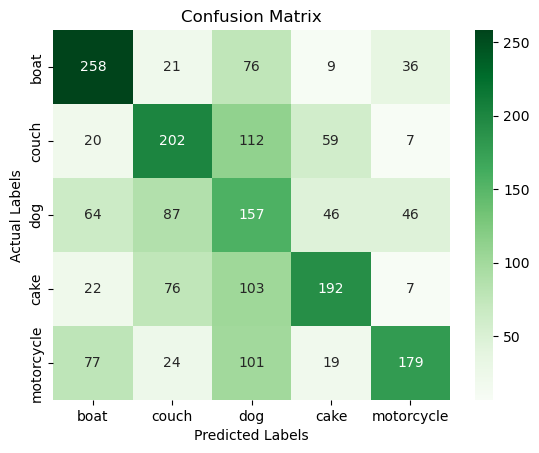

In [169]:
net2 = HW4Net("Net2")
epochs_net2 = 15
batch_size_net2 = 4
net2_training_loss = model_training(net2, epochs_net2, train_dataloader, torch.device("mps"), os.path.join('/Users/avnishkanungo/Desktop/coco-dataset/train2017', 'net2.pth'))
confusion_matrix_net2, net2_testing_acc = model_testing(net2, test_dataloader, batch_size_net2, torch.device("mps"), classes,os.path.join('/Users/avnishkanungo/Desktop/coco-dataset/train2017', 'net2.pth'))
#plot_confusion_martix(confusion_matrix_net2, 'Confusion Matrix for Net2, Accuracy: {}'.format(testing_acc_net2), classes)

Begin Training...

[epoch: 1, batch:   100] loss: 1.620309
[epoch: 1, batch:   200] loss: 1.611637
[epoch: 1, batch:   300] loss: 1.612545
[epoch: 1, batch:   400] loss: 1.610768
[epoch: 1, batch:   500] loss: 1.610098
[epoch: 1, batch:   600] loss: 1.609449
[epoch: 1, batch:   700] loss: 1.610320
[epoch: 1, batch:   800] loss: 1.608281
[epoch: 1, batch:   900] loss: 1.614990
[epoch: 1, batch:  1000] loss: 1.610173
[epoch: 1, batch:  1100] loss: 1.609639
[epoch: 1, batch:  1200] loss: 1.605697
[epoch: 1, batch:  1300] loss: 1.609151
[epoch: 1, batch:  1400] loss: 1.611786
[epoch: 1, batch:  1500] loss: 1.612287
[epoch: 1, batch:  1600] loss: 1.610610
[epoch: 1, batch:  1700] loss: 1.611701
[epoch: 1, batch:  1800] loss: 1.607203
[epoch: 1, batch:  1900] loss: 1.614749
[epoch: 1, batch:  2000] loss: 1.610127
[epoch: 2, batch:   100] loss: 1.609923
[epoch: 2, batch:   200] loss: 1.611317
[epoch: 2, batch:   300] loss: 1.612667
[epoch: 2, batch:   400] loss: 1.610132
[epoch: 2, batch:   5

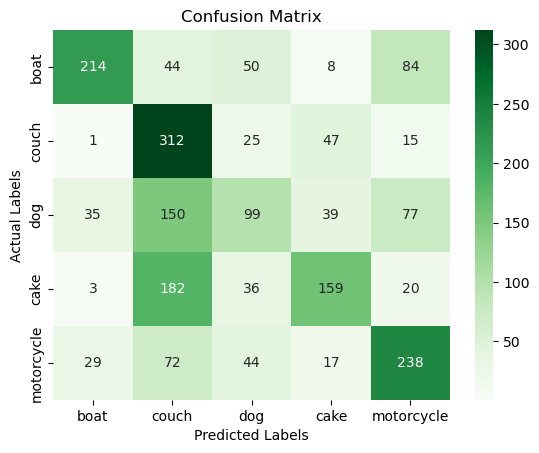

In [166]:
net3 = HW4Net("Net3")
net3.apply(weights_init)
epochs_net3 = 15
batch_size_net3 = 4
net3_training_loss = model_training(net3, epochs_net3, train_dataloader, torch.device("mps"), os.path.join('/Users/avnishkanungo/Desktop/coco-dataset/train2017', 'net3.pth'))
confusion_matrix_net3, net3_testing_acc = model_testing(net3, test_dataloader, batch_size_net3, torch.device("mps"), classes,os.path.join('/Users/avnishkanungo/Desktop/coco-dataset/train2017', 'net3.pth'))
#plot_confusion_martix(confusion_matrix_net3, 'Confusion Matrix for Net2, Accuracy: {}'.format(testing_acc_net3), classes)

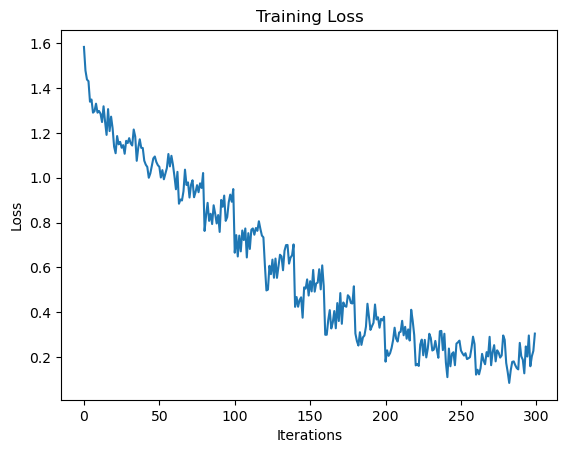

In [149]:
plt.figure()     
plt.plot(net1_training_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title("Training Loss")
plt.show()

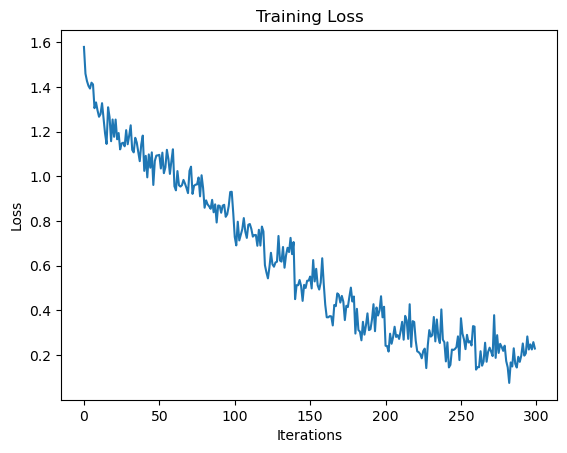

In [150]:
plt.figure()     
plt.plot(net2_training_loss) 
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title("Training Loss")
plt.show()

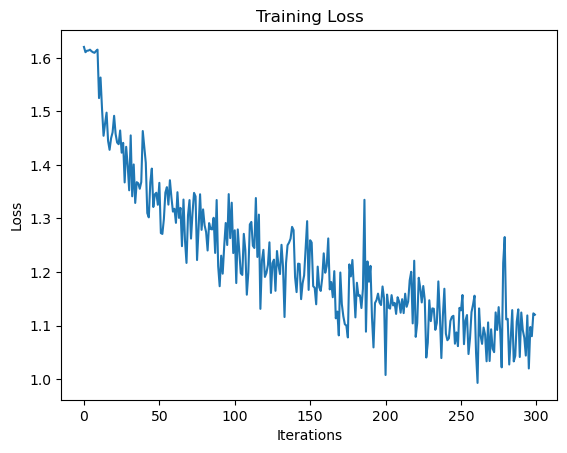

In [151]:
plt.figure()     
plt.plot(net3_training_loss) 
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title("Training Loss")
plt.show()

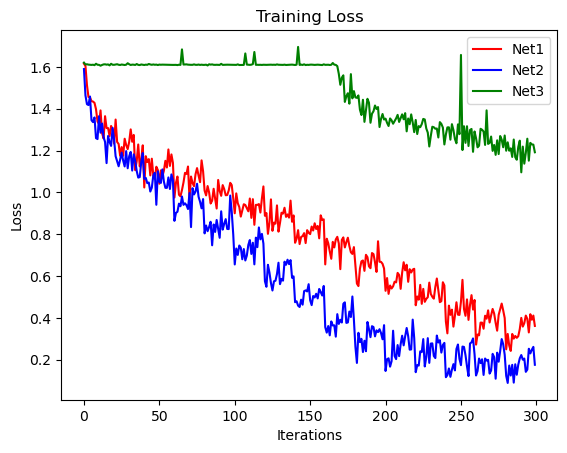

In [170]:
plt.plot(net1_training_loss, 'r', label='Net1')
plt.plot(net2_training_loss, 'b', label='Net2')
plt.plot(net3_training_loss, 'g', label='Net3')
plt.title("Training Loss")
plt.legend(loc="upper right")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [145]:
def count_parameters(model):  #Count network parameters
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [146]:
count_parameters(net1) # Count Net1 Parameters

406885

In [147]:
count_parameters(net2) # Count Net2 Parameters

529765

In [148]:
count_parameters(net3) # Count Net3 Parameters

622245